# Kaggle Competition - Titanic Spaceship

## Introduction

The following is a model that tries to predict whether passengers in a test set provided by Kaggle have been teleported in an alternate dimension. 
The model reaches a hold out accuracy of 0.813 with satisfying F1 scores and balanced scores. The overall accuracyon the test set is 0.8033, placing me 220th over 1695 participants and teams. The project is in progress as better imputation methods will be tested in order to improve prediction accuracy.

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [33]:
# Load the dataset
data = pd.read_csv('train.csv')

In [34]:
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Exploratory Data Analysis

In [36]:
# Distribution of the target variable
target_dist = data['Transported'].value_counts(normalize=True)
target_dist

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

<ipython-input-37-4d3dbb99c27c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_dist.index, y=target_dist.values, palette="viridis")


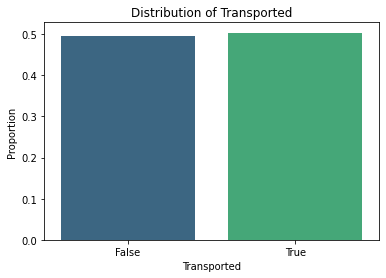

In [37]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.barplot(x=target_dist.index, y=target_dist.values, palette="viridis")
plt.title("Distribution of Transported")
plt.xlabel("Transported")
plt.ylabel("Proportion")
plt.show()

In [38]:
# Checking missing values across the dataset
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(data)) * 100

In [39]:
# Creating a dataframe for visualization
missing_data = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_percentage
})

# Display the missing data summary
print(missing_data)

              Missing Values  Percentage
CryoSleep                217    2.496261
ShoppingMall             208    2.392730
VIP                      203    2.335212
HomePlanet               201    2.312205
Name                     200    2.300702
Cabin                    199    2.289198
VRDeck                   188    2.162660
FoodCourt                183    2.105142
Spa                      183    2.105142
Destination              182    2.093639
RoomService              181    2.082135
Age                      179    2.059128
PassengerId                0    0.000000
Transported                0    0.000000


<ipython-input-40-65a2dfd90c82>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_patterns.index, y=missing_patterns.values, palette="viridis")


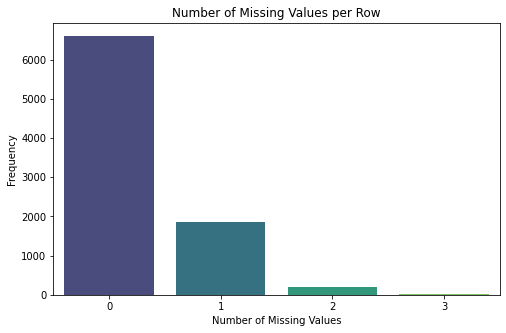

         Feature  Correlation with Transported
9   ShoppingMall                      0.013920
7    RoomService                     -0.013142
8      FoodCourt                      0.010957
11        VRDeck                      0.005249
2      CryoSleep                     -0.004846
1     HomePlanet                      0.002712
6            VIP                      0.002688
10           Spa                     -0.001864
4    Destination                      0.000547
12          Name                      0.000422
3          Cabin                     -0.000340
5            Age                     -0.000241
0    PassengerId                           NaN
13   Transported                           NaN


In [40]:
# Checking if missing values are random by analyzing patterns of missingness
missing_patterns = data.isnull().sum(axis=1).value_counts()

# Correlation of missing values with the target variable
missing_corr = data.isnull().astype(int).corrwith(data['Transported'])

# Visualize missingness distribution across rows
plt.figure(figsize=(8, 5))
sns.barplot(x=missing_patterns.index, y=missing_patterns.values, palette="viridis")
plt.title("Number of Missing Values per Row")
plt.xlabel("Number of Missing Values")
plt.ylabel("Frequency")
plt.show()

# Display correlation of missingness with the target variable
missing_corr_df = pd.DataFrame({
    "Feature": missing_corr.index,
    "Correlation with Transported": missing_corr.values
}).sort_values(by="Correlation with Transported", key=abs, ascending=False)
print(missing_corr_df)


There isn't correlation of missing values with the target, at least not linear. Either way, dropping rows would result in 2000+ lost data points, which is quiet substantial. Furthermore, the test set also has missing values. Were we to drop rows with missing values, we would train a model that would not handle well such instances. We decide to go for imputation

## Handling Missing Values

In [41]:
# Handle missing values
# For numerical features: Fill missing values with the mean
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace=True)

In [42]:
# For categorical features: Fill missing values with the mode
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Cabin', 'VIP']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [43]:
# Parse Cabin into Deck, RoomNumber, and Side
data['Deck'] = data['Cabin'].str[0]  # First character
data['RoomNumber'] = data['Cabin'].str.extract('(\d+)').astype(float)  # Numeric part
data['Side'] = data['Cabin'].str[-1]  # Last character

## Data Preparation

In [44]:
# Encode categorical variables
label_encoders = {}
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'VIP']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [45]:
# Normalize numerical features if necessary
for col in numerical_cols + ['RoomNumber']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [46]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,RoomNumber,Side
0,0001_01,1,0,B/0/P,2,0.709396,0,-0.340570,-0.287298,-0.290800,-0.276648,-0.269007,Maham Ofracculy,False,1,-1.191675,0
1,0002_01,0,0,F/0/S,2,-0.336698,0,-0.175354,-0.281653,-0.248954,0.211493,-0.230181,Juanna Vines,True,5,-1.191675,1
2,0003_01,1,0,A/0/S,2,2.034449,1,-0.275393,1.955503,-0.290800,5.693962,-0.225769,Altark Susent,False,0,-1.191675,1
3,0003_02,1,0,A/0/S,2,0.290958,0,-0.340570,0.517376,0.330206,2.683316,-0.098702,Solam Susent,False,0,-1.191675,1
4,0004_01,0,0,F/1/S,2,-0.894615,0,0.118702,-0.243395,-0.038046,0.225719,-0.267242,Willy Santantines,True,5,-1.189701,1


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int64  
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   int64  
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   int64  
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Deck          8693 non-null   int64  
 15  RoomNumber    8693 non-null   float64
 16  Side          8693 non-null   int64  
dtypes: bool(1), float64(7), int64(6), object(3)
memory usage: 1.1+ MB


## Model Building

### Feature Engineering

We introduce linear and non-linear interactions among correlated features, thus improving hold-out accuracy.

### Model choice

The better-performing model is an XGboost with standard hyperparameters.

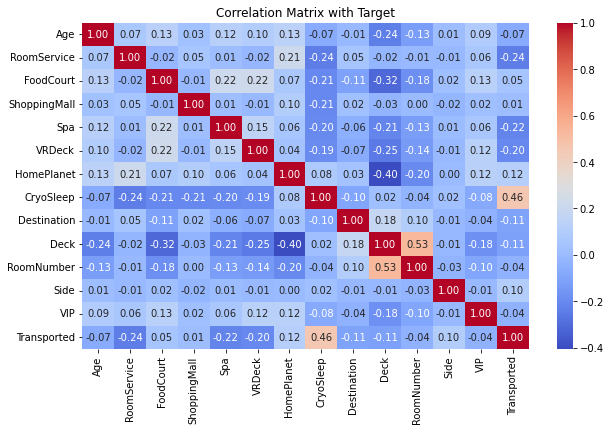

In [48]:
features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'RoomNumber', 'Side', 'VIP']
correlation_matrix = data[features + ['Transported']].corr()
# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix with Target")
plt.show()

In [49]:
data['HomePlanet_Deck'] = data['HomePlanet'] * data['Deck']
data['HomePlanet_RoomNumber'] = data['HomePlanet'] * data['RoomNumber']
data['Age_Deck'] = data['Age'] * data['Deck']**2
data['RoomService_CryoSleep'] = data['RoomService'] * data['CryoSleep']**2
data['Deck_VRDeck'] = (data['Deck']**2) * data['VRDeck']
data['Deck_FoodCourt'] = data['Deck'] * data['FoodCourt']**2

# Features and target
features = ['Age', 'RoomService','FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet', 'CryoSleep', 'Destination','RoomNumber', 
            'Deck', 'Side','HomePlanet_RoomNumber','HomePlanet_Deck',
            'RoomService_CryoSleep', 'Deck_VRDeck', 'Deck_FoodCourt']
X = data[features]
y = data['Transported'].astype(int)  # Encode the target variable as 0/1

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Predict on the holdout test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model on the test set
print("\nHoldout Test Set Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:14:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:14:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:14:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:14:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/x

Cross-Validation Accuracy Scores: [0.80661395 0.81595974 0.80733285 0.80733285 0.81151079]
Mean Accuracy: 0.8098
Standard Deviation: 0.0036

Holdout Test Set Results:
Accuracy: 0.8131109833237493

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       861
           1       0.82      0.81      0.81       878

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:14:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Test Set - Preparation and model application

In [50]:
test_set = pd.read_csv('test.csv')

# Handle missing values
# For numerical features: Fill missing values with the mean
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in numerical_cols:
    test_set[col].fillna(test_set[col].mean(), inplace=True)

# For categorical features: Fill missing values with the mode
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Cabin', 'VIP']
for col in categorical_cols:
    test_set[col].fillna(test_set[col].mode()[0], inplace=True)
    
    
# Parse Cabin into Deck, RoomNumber, and Side
test_set['Deck'] = test_set['Cabin'].str[0]  # First character
test_set['RoomNumber'] = test_set['Cabin'].str.extract('(\d+)').astype(float)  # Numeric part
test_set['Side'] = test_set['Cabin'].str[-1]  # Last character

# Encode categorical variables
label_encoders = {}
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'VIP']:
    le = LabelEncoder()
    test_set[col] = le.fit_transform(test_set[col].astype(str))
    label_encoders[col] = le  # Save encoder for consistency with test set
    
# Normalize numerical features if necessary
for col in numerical_cols + ['RoomNumber']:
    test_set[col] = (test_set[col] - test_set[col].mean()) / test_set[col].std()

In [51]:
features = ['Age', 'RoomService','FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet', 'CryoSleep', 'Destination','RoomNumber', 
            'Deck', 'Side','HomePlanet_RoomNumber','HomePlanet_Deck',
            'RoomService_CryoSleep', 'Deck_VRDeck', 'Deck_FoodCourt']
X = data[features]
y = data['Transported'].astype(int)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model on the training set
xgb_model.fit(X, y)

test_set['HomePlanet_Deck'] = test_set['HomePlanet'] * test_set['Deck']
test_set['HomePlanet_RoomNumber'] = test_set['HomePlanet'] * test_set['RoomNumber']
test_set['Age_Deck'] = test_set['Age'] * test_set['Deck']**2
test_set['RoomService_CryoSleep'] = test_set['RoomService'] * test_set['CryoSleep']**2
test_set['Deck_VRDeck'] = (test_set['Deck']**2) * test_set['VRDeck']
test_set['Deck_FoodCourt'] = test_set['Deck'] * test_set['FoodCourt']**2

# Predict on the holdout test set
y_pred = xgb_model.predict(test_set[features])

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:17:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Output Preparation

In [52]:
ident = test_set['PassengerId']
df = pd.DataFrame(ident, columns=['PassengerId'])
df['Transported'] = y_pred.astype('bool')
df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [53]:
df.to_csv('submission.csv', index=False)